PartC: Bonus Challenges (Optional, 100pts)
Predictive Analysis: Use linear regression to forecast next month’s sales.
Interactive Dashboard: Build a simple Streamlit app to filter data by region/category.
Customer RFM Analysis: Segment customers by Recency, Frequency, Monetary value.

### Explanation of My RFM Analysis Code

This section explains the steps I took in the Python code to perform the RFM (Recency, Frequency, Monetary) analysis for the bonus challenge. The goal was to segment customers based on their past purchasing behavior.

**1. Imports:**

* I started by importing the necessary libraries.
* `import pandas as pd`: This was essential for reading the data and doing all the manipulations like grouping and calculating.
* `import datetime as dt`: I needed this to work with dates, specifically to calculate the difference between the last purchase date and a reference date for Recency.
* `import matplotlib.pyplot as plt` and `import seaborn as sns`: These were for creating the final bar chart visualizing the customer segments.
* *(I also used NumPy implicitly through pandas, and later needed `tabulate` for the `.to_markdown()` display, which I installed separately).*

**2. Load and Prep Data:**

* **Load Data:** Similar to the other analyses, I loaded the `Superstore.csv` file into a pandas DataFrame, which I called `sales_df` in this version.
* **Convert Dates:** Making sure the `Order Date` column was in the correct datetime format was crucial. I used `pd.to_datetime` for this, handling potential errors, and removed any rows where the date couldn't be converted.

**3. Calculate R, F, M Components:**

* **Reference Date:** To calculate Recency (how long ago someone purchased), I first found the very last `Order Date` in the whole dataset and added one day to it. This `snapshot_date` became my consistent point of reference.
* **Aggregate per Customer:** The core of RFM is looking at each customer individually. I used `sales_df.groupby('Customer ID').agg(...)` to calculate three things for each customer:
    * `Last_Purchase_Date`: The most recent `Order Date` for that customer.
    * `Total_Orders`: The count of unique `Order ID`s for that customer (this became my **Frequency**).
    * `Total_Spent`: The sum of all `Sales` for that customer (this became my **Monetary** value).
* **Calculate Recency:** After aggregating, I calculated the **Recency** for each customer by finding the number of days between the `snapshot_date` and their `Last_Purchase_Date`.
* **Clean Up:** I renamed the aggregated columns to the standard 'Frequency' and 'Monetary' and kept only the necessary columns (`Customer ID`, `Recency`, `Frequency`, `Monetary`) in a new DataFrame called `rfm_calc`.

**4. Create RFM Scores:**

* **Scoring Logic:** Raw RFM values are hard to compare directly, so I converted them into scores from 1 to 5. I used quantiles (`pd.qcut`) to do this, which basically divides all customers into 5 roughly equal groups for each metric (R, F, M).
    * **Recency Score (R_Score):** Customers who purchased more recently (lower `Recency` days) got a higher score (5), while those who purchased long ago got a lower score (1).
    * **Frequency Score (F_Score):** Customers who purchased more often (higher `Frequency`) got a higher score (5). I used `.rank(method='first')` here before `qcut` to help handle customers with the exact same frequency count more consistently.
    * **Monetary Score (M_Score):** Customers who spent more (higher `Monetary` value) got a higher score (5).
* **Combine Scores:** I then created a combined score string (like '555' or '123') by joining the individual R, F, and M scores. This gives a quick snapshot of a customer's profile.

**5. Segmentation:**

* **Define Segments:** Based on the R, F, and M scores, I defined rules to group customers into meaningful segments. I created a function (`get_customer_segment`) that looked at the scores and assigned a descriptive name like "Top Tier", "Loyal", "At Risk / Slipping Loyal", "New / Potential", or "Hibernating / Lost". *These segment definitions are a bit subjective and could be adjusted based on business goals.*
* **Apply Segmentation:** I applied this function to each row of my `rfm_calc` DataFrame to create the final `Segment` column.

**6. Show Results & Visualize:**

* **Display Table:** I printed the first few rows of the final `rfm_calc` DataFrame, now including the R, F, M scores and the assigned `Segment`.
* **Count Segments:** I calculated how many customers fell into each segment using `.value_counts()` and displayed this summary table.
* **Plot Segments:** Finally, I used `seaborn.barplot` to create a bar chart showing the number of customers in each segment, making it easy to visually compare the size of different customer groups.



In [11]:
# --- Part C: Bonus Challenge - RFM Analysis ---
# Goal: Segment customers based on Recency, Frequency, Monetary value

# Import required libraries
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data & Basic Prep ---

# Load the dataset
# (Make sure 'Superstore.csv' is in the right place)
try:
    sales_df = pd.read_csv('Superstore.csv', encoding='cp1252')
    print("Data loaded.")
except FileNotFoundError:
    print("Error: Superstore.csv not found.")
    # In a real script/notebook, you might stop execution here
    # For this example, we'll assume 'sales_df' would be loaded
    # or raise an error if it continues without it.
    raise # Stop execution if file not found

# Need 'Order Date' as a proper date format
# This conversion is crucial and must happen before calculating .max()
sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'], format='%m/%d/%Y', errors='coerce')
sales_df.dropna(subset=['Order Date'], inplace=True) # Remove rows if date conversion failed
print("'Order Date' converted to datetime format.")


Data loaded.
'Order Date' converted to datetime format.


In [12]:
# --- 2. Calculate R, F, M Components ---

# Figure out the snapshot date for recency (day after the last order)
last_order_date = sales_df['Order Date'].max()
# Check the type to be sure (optional debug)
# print(f"Type of last_order_date before adding timedelta: {type(last_order_date)}")
snapshot_date = last_order_date + dt.timedelta(days=1)
print(f"Snapshot date for analysis: {snapshot_date.strftime('%Y-%m-%d')}")

# Aggregate data per customer
# Using .agg for multiple calculations at once
customer_summary = sales_df.groupby('Customer ID').agg(
    Last_Purchase_Date=('Order Date', 'max'),      # Find last purchase date
    Total_Orders=('Order ID', 'nunique'),     # Count unique orders (Frequency)
    Total_Spent=('Sales', 'sum')              # Sum sales (Monetary)
).reset_index()

# Calculate Recency: days between snapshot date and last purchase
customer_summary['Recency'] = (snapshot_date - customer_summary['Last_Purchase_Date']).dt.days

# Rename columns for clarity to standard RFM
customer_summary.rename(columns={'Total_Orders': 'Frequency',
                                 'Total_Spent': 'Monetary'}, inplace=True)

# Keep only the core RFM columns + Customer ID
rfm_calc = customer_summary[['Customer ID', 'Recency', 'Frequency', 'Monetary']].copy()
print("RFM base values calculated.")



Snapshot date for analysis: 2017-12-31
RFM base values calculated.


In [13]:
# --- 3. Create RFM Scores ---

# Define score labels (1-5)
# Lower Recency is better (score 5)
recency_scores = [5, 4, 3, 2, 1]
# Higher Frequency/Monetary is better (score 5)
fm_scores = [1, 2, 3, 4, 5]

# Calculate scores based on quantiles (split into 5 groups)
# Need to handle potential duplicate quantile edges with duplicates='drop'
# Ranking Frequency first helps break ties more consistently for qcut
rfm_calc['R_Score'] = pd.qcut(rfm_calc['Recency'], 5, labels=recency_scores, duplicates='drop')
rfm_calc['F_Score'] = pd.qcut(rfm_calc['Frequency'].rank(method='first'), 5, labels=fm_scores, duplicates='drop')
rfm_calc['M_Score'] = pd.qcut(rfm_calc['Monetary'], 5, labels=fm_scores, duplicates='drop')

# Make sure scores are integers
rfm_calc[['R_Score', 'F_Score', 'M_Score']] = rfm_calc[['R_Score', 'F_Score', 'M_Score']].astype(int)
print("RFM scores assigned.")



RFM scores assigned.


In [14]:
# --- 4. Segmentation ---

# Combine scores for easy reference
rfm_calc['RFM_Score_Combined'] = rfm_calc['R_Score'].astype(str) + \
                                 rfm_calc['F_Score'].astype(str) + \
                                 rfm_calc['M_Score'].astype(str)

# Define segmentation logic (these rules are subjective, adjust as needed for project story)
def get_customer_segment(row):
    R, F, M = row['R_Score'], row['F_Score'], row['M_Score']

    if R >= 4 and F >= 4: # Recent & Frequent
        # Separate top tier based on Monetary score
        return "Top Tier" if M == 5 else "Loyal"
    elif R >= 4 and F < 3: # Recent & Infrequent
        return "New / Potential"
    elif R < 3 and F >= 4: # Not Recent & Frequent
        return "At Risk / Slipping Loyal"
    elif R < 3 and F < 3: # Not Recent & Infrequent
        # Separate based on value
        return "Hibernating / Lost" if M < 3 else "Lost High Value"
    else: # Catch other mid-range groups
        return "Average / Needs Nurturing"

# Create the segment column
rfm_calc['Segment'] = rfm_calc.apply(get_customer_segment, axis=1)
print("Segmentation complete.")



Segmentation complete.



Final RFM Analysis Table (Sample):
| Customer ID   |   Recency |   Frequency |   Monetary |   R_Score |   F_Score |   M_Score |   RFM_Score_Combined | Segment                   |
|:--------------|----------:|------------:|-----------:|----------:|----------:|----------:|---------------------:|:--------------------------|
| AA-10315      |       185 |           5 |   5563.56  |         2 |         2 |         5 |                  225 | Lost High Value           |
| AA-10375      |        20 |           9 |   1056.39  |         5 |         5 |         2 |                  552 | Loyal                     |
| AA-10480      |       260 |           4 |   1790.51  |         1 |         1 |         3 |                  113 | Lost High Value           |
| AA-10645      |        56 |           6 |   5086.93  |         3 |         3 |         5 |                  335 | Average / Needs Nurturing |
| AB-10015      |       416 |           3 |    886.156 |         1 |         1 |         1 |        

/var/folders/rk/gh7_0ltx2v71ltw25mck4xrm0000gn/T/ipykernel_2002/1693522612.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_counts, x='Customer Count', y='Segment', palette='viridis')


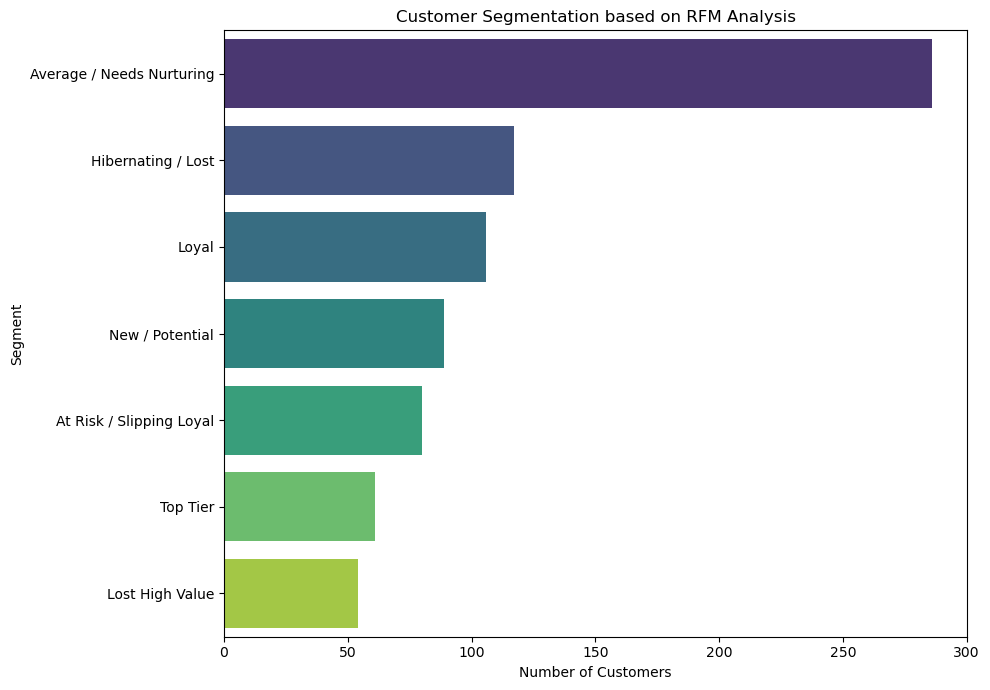

In [15]:
# --- 5. Show Results & Visualize ---

print("\nFinal RFM Analysis Table (Sample):")
# Displaying more rows might be useful
print(rfm_calc.head(15).to_markdown(index=False))

# Show segment counts
print("\nCustomer Count per Segment:")
segment_counts = rfm_calc['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Customer Count']
print(segment_counts.to_markdown(index=False))

# Visualize the segments
print("\nVisualizing Customer Segments:")
plt.figure(figsize=(10, 7)) # Adjusted figure size for potentially longer labels
sns.barplot(data=segment_counts, x='Customer Count', y='Segment', palette='viridis')
plt.title('Customer Segmentation based on RFM Analysis')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [16]:
# --- Part C: Bonus Challenge - Predictive Analysis ---
# Goal: Forecast next month's sales using basic Linear Regression

### Explanation of My Predictive Analysis Code

Here's a breakdown of the Python code I wrote to forecast the next month's sales using linear regression for the bonus challenge.

**1. Imports:**

* First, I needed to import the specific libraries for this part.
* `import numpy as np`: I used NumPy mainly for creating the numerical time index (`np.arange`) and for formatting the prediction input correctly for scikit-learn later on.
* `from sklearn.linear_model import LinearRegression`: This imports the actual Linear Regression model from the scikit-learn library, which does the work of finding the trend line.
* *(I assumed that `pandas`, `datetime`, `matplotlib.pyplot`, and `seaborn` were already imported in earlier parts of my notebook, like during the RFM analysis, so I didn't re-import them here).*

**2. Load and Prep Data:**

* **Load Data:** I started by loading the `Superstore.csv` into a pandas DataFrame, which I called `store_data`. I added a `try-except` block just in case the file wasn't found.
* **Convert Dates:** It was really important to convert the `Order Date` column into actual datetime objects using `pd.to_datetime`. This lets pandas understand them as dates, which is necessary for grouping by month.
* **Handle Errors:** I used `errors='coerce'` so any weird date formats would become `NaT` (Not a Time), and then I used `dropna` to remove those rows just to be safe and avoid errors later.

**3. Aggregate by Month & Create Feature:**

* **Aggregate:** To see the overall trend, I needed the total sales for each month. I did this by:
    * Setting `Order Date` as the index (`set_index`).
    * Using `.resample('M')` to group the data into monthly bins.
    * Calculating the `.sum()` of `Sales` for each month.
    * Using `.reset_index()` to turn it back into a normal DataFrame.
* **Create Time Feature:** For the linear regression, I needed a simple number representing time. I created the `Month_Num` column using `np.arange(len(sales_by_month))`, which just creates a sequence: 0 for the first month, 1 for the second, and so on. This acts as my X-variable.

**4. Train the Basic Regression Model:**

* **Prepare X and y:** I set up the input for the model. `X_time` holds my feature (`Month_Num`). I used double brackets `[['Month_Num']]` to make it a 2D structure, which scikit-learn expects. `y_sales` holds the target I want to predict (the actual monthly `Sales`).
* **Create Model:** I created an instance of the `LinearRegression` model.
* **Train Model:** The `.fit(X_time, y_sales)` step is where the learning happens. The model looks at my historical `Month_Num` and `Sales` data and calculates the best-fitting straight line (slope and intercept) to describe the relationship.

**5. Predict the Next Month:**

* **Get Next Month Index:** I found the last month number in my data (`.max()`) and added 1 to it to get the index for the month I wanted to forecast.
* **Predict:** I used the `.predict()` method of my trained `trend_model`. I had to give it the `next_month_num` wrapped in `np.array([[...]])` so it was in the 2D format the model expects. The result, `forecast_value`, is the predicted sales amount.

**6. Plot Everything:**

* **Setup Plot:** I created a figure to draw on using `plt.figure()`.
* **Plot Actual Data:** I used `sns.lineplot` to show the real historical monthly sales data as points connected by lines.
* **Plot Trend Line:** I used `plt.plot` to draw the straight line calculated by the linear regression model across the historical period.
* **Plot Forecast:** I used `plt.scatter` to draw a single, noticeable point showing the predicted sales value for the next month.
* **Formatting:** Finally, I added labels, a title, a legend to explain what's what, a grid, and used `plt.show()` to display the finished plot. This visualization helps see how the simple linear trend compares to the actual sales.


Data loaded successfully for regression.
'Order Date' converted to datetime format.

Monthly Sales Data with Time Index (Sample):
| Order Date          |    Sales |   Time_Index |
|:--------------------|---------:|-------------:|
| 2014-01-31 00:00:00 | 14236.9  |            0 |
| 2014-02-28 00:00:00 |  4519.89 |            1 |
| 2014-03-31 00:00:00 | 55691    |            2 |
| 2014-04-30 00:00:00 | 28295.3  |            3 |
| 2014-05-31 00:00:00 | 23648.3  |            4 |

Linear Regression Model Trained.
  Intercept: 26661.17
  Coefficient (Slope): 902.01

Predicted Sales for next month (Time Index 48): $69,957.54

Visualizing Trend and Forecast:


/var/folders/rk/gh7_0ltx2v71ltw25mck4xrm0000gn/T/ipykernel_2002/2131077138.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = sales_df.set_index('Order Date').resample('M')['Sales'].sum().reset_index()
/Applications/anaconda3/envs/pyproject_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


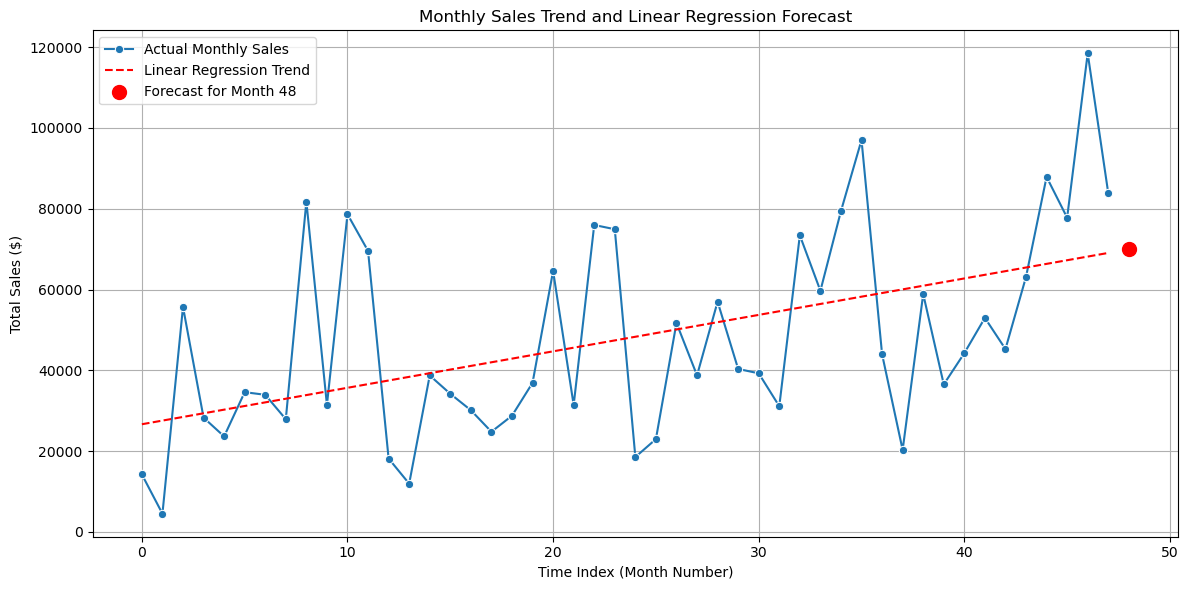

In [19]:

# Imports specific to this analysis
import numpy as np
from sklearn.linear_model import LinearRegression

# --- 1. Load and Prepare Data ---
# Load data and parse dates correctly (keeping this for robustness)

try:
    # Define the variable 'sales_df' by loading the CSV
    sales_df = pd.read_csv('Superstore.csv', encoding='cp1252')
    print("Data loaded successfully for regression.")
except FileNotFoundError:
    print("Error: Superstore.csv not found. Please ensure the file is in the correct directory.")
    raise # Stop if file not found

# Convert 'Order Date' to datetime objects - CRUCIAL step
sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'], format='%m/%d/%Y', errors='coerce')
sales_df.dropna(subset=['Order Date'], inplace=True) # Remove rows if date conversion failed
print("'Order Date' converted to datetime format.")


# --- 2. Aggregate Data and Create Features ---

# Aggregate total sales by month
monthly_sales = sales_df.set_index('Order Date').resample('M')['Sales'].sum().reset_index()

# Create a simple numerical time index (0, 1, 2, ...)
monthly_sales['Time_Index'] = np.arange(len(monthly_sales))

print("\nMonthly Sales Data with Time Index (Sample):")
# Use .to_markdown if tabulate is installed, otherwise use print()
try:
    print(monthly_sales[['Order Date', 'Sales', 'Time_Index']].head().to_markdown(index=False))
except ImportError:
    print(monthly_sales[['Order Date', 'Sales', 'Time_Index']].head())


# --- 3. Train Linear Regression Model ---

# Prepare data for scikit-learn
X = monthly_sales[['Time_Index']] # Feature (X) needs to be 2D
y = monthly_sales['Sales']        # Target (y)

# Create and train the model
lin_reg_model = LinearRegression()
lin_reg_model.fit(X, y)

print(f"\nLinear Regression Model Trained.")
print(f"  Intercept: {lin_reg_model.intercept_:.2f}")
print(f"  Coefficient (Slope): {lin_reg_model.coef_[0]:.2f}")


# --- 4. Predict Next Month's Sales ---

# Find the next time index value
last_time_index = monthly_sales['Time_Index'].max()
next_time_index = last_time_index + 1

# Predict for the next time index
next_month_prediction = lin_reg_model.predict(np.array([[next_time_index]]))

print(f"\nPredicted Sales for next month (Time Index {next_time_index}): ${next_month_prediction[0]:,.2f}")


# --- 5. Visualize the Results ---

print("\nVisualizing Trend and Forecast:")
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Time_Index', y='Sales', marker='o', label='Actual Monthly Sales')
plt.plot(X, lin_reg_model.predict(X), color='red', linestyle='--', label='Linear Regression Trend')
plt.scatter([next_time_index], next_month_prediction, color='red', s=100, zorder=5, label=f'Forecast for Month {next_time_index}')
plt.title('Monthly Sales Trend and Linear Regression Forecast')
plt.xlabel('Time Index (Month Number)')
plt.ylabel('Total Sales ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()